
In this notebook, we will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Validate the Loss function
- Do prediction for the test data

In [ ]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')


In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"   # map 'keras' to tf.keras (what Transformers expects on TF 2.15)

import tensorflow as tf
print("TF:", tf.__version__)   

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



TF: 2.15.0


# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('Training Set Shape = {}'.format(df_train.shape))

print('Test Set Shape = {}'.format(df_test.shape))


Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64




Note that all the tweets are in english.

# Preprocess the data

In [7]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [9]:
# Load a DistilBERT model.
MODEL_NAME = "distilbert-base-uncased"   # same as your Keras preset
MAX_LEN = 160                            # shorter sequence length for tweets

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
classifier = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2     # binary classification (same as num_classes=2)
)

# 2. Print summary-like info
classifier.summary()   

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


c:\Users\Hritik\Documents\Disaster_Categorization\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hritik\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDist

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train your own model, fine-tuning BERT

In [11]:
# Compile

train_enc = tokenizer(
    list(X_train),
    padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="tf"
)
val_enc = tokenizer(
    list(X_val),
    padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="tf"
)

X_train_inputs = {
    "input_ids": train_enc["input_ids"],
    "attention_mask": train_enc["attention_mask"],
}
X_val_inputs = {
    "input_ids": val_enc["input_ids"],
    "attention_mask": val_enc["attention_mask"],
}

# 2) Compile (2-logit head → use SparseCategoricalCrossentropy(from_logits=True))
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = classifier.fit(
    x=X_train_inputs,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_inputs, y_val),
)

Epoch 1/2
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



191/191 [==============================] - 1763s 9s/step - loss: 0.4878 - accuracy: 0.7704 - val_loss: 0.4124 - val_accuracy: 0.8260
Epoch 2/2
191/191 [==============================] - 2002s 10s/step - loss: 0.3651 - accuracy: 0.8524 - val_loss: 0.3888 - val_accuracy: 0.8404


In [12]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


In [ ]:
y_pred_train = classifier.predict(X_train_inputs)



191/191 [==============================] - 518s 3s/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:

y_pred_labels = tf.argmax(y_pred_train.logits, axis=-1).numpy()
print(y_pred_labels[:20])

[1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1]


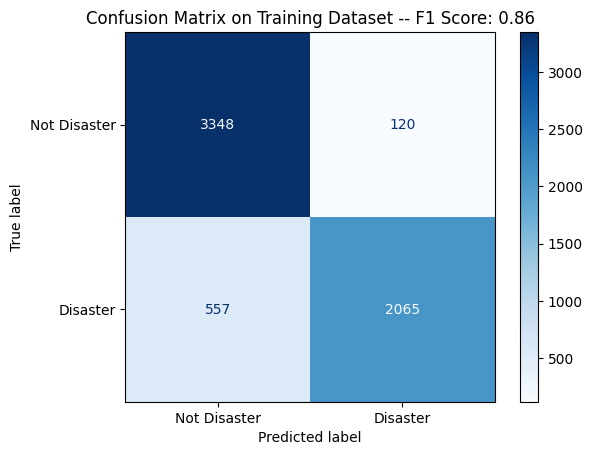

In [20]:
displayConfusionMatrix(y_train, y_pred_train.logits, "Training")

48/48 [==============================] - 120s 2s/step


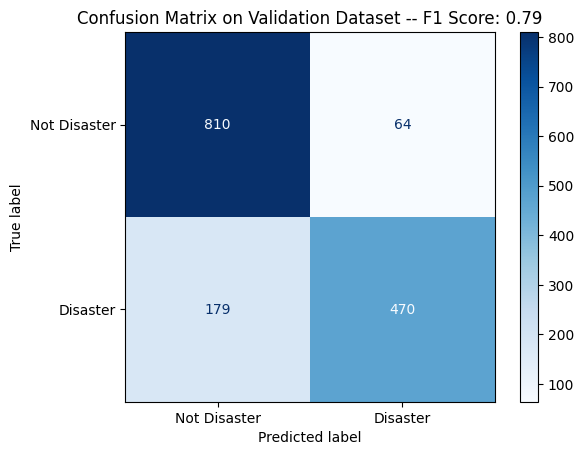

In [21]:
y_pred_val = classifier.predict(X_val_inputs)

displayConfusionMatrix(y_val, y_pred_val.logits, "Validation")

In [24]:
y_test_pred_labels = tf.argmax(y_pred_val.logits, axis=-1).numpy()
print(y_test_pred_labels[:20])

[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0]


In [39]:
X_test.shape

(3263,)

In [40]:
X_test_Val = tokenizer(
    list(X_test),
    padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="tf"
)

X_test_inputs = {
    "input_ids": X_test_Val["input_ids"],
    "attention_mask": X_test_Val["attention_mask"],}

In [42]:
y_test_pred_val = classifier.predict(X_test_inputs)

102/102 [==============================] - 258s 3s/step


In [43]:
test_pred_labels = tf.argmax(y_test_pred_val.logits, axis=-1).numpy()

In [44]:
X_test = df_test["text"]   # test text
ids    = df_test["id"]   

In [46]:
Prediction = pd.DataFrame({
    "id": ids,
    "text": X_test,
    "target": test_pred_labels
})

In [47]:
Prediction.to_csv("prediction.csv", index=False)